In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision, MeanIoU

from tensorflow.keras import backend as K
import time

2024-02-15 04:20:32.782070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 04:20:32.782174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 04:20:32.943278: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# np.random.seed(42)
# tf.random.set_seed(42)

# IMAGE_SIZE = 128
# EPOCHS = 70
# BATCH = 8

# PATH = "/kaggle/input/final-dataset"




# def read_image(path):
#     path = path.decode()
#     x = cv2.imread(path, cv2.IMREAD_COLOR)
#     x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
#     x = x/255.0
#     return x


# def tf_parse(x, y):
#     def _parse(x, y):
#         x = read_image(x)
#         y = read_image(y)
#         return x, y

#     x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
#     x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
#     y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
#     return x, y

# def tf_dataset(x, y, batch=8):
#     dataset = tf.data.Dataset.from_tensor_slices((x, y))
#     dataset = dataset.map(tf_parse)
#     dataset = dataset.batch(batch)
#     dataset = dataset.repeat()
#     return dataset


# train_x_folder_path = "/kaggle/input/lits-dataset/LiTS_liver_tr_val_te/train/CT Images"
# train_x_file_names = os.listdir(train_x_folder_path)
# train_x = [os.path.join(train_x_folder_path, file_name) for file_name in train_x_file_names]
# # train_x

# train_y_folder_path = "/kaggle/input/lits-dataset/LiTS_liver_tr_val_te/train/Liver Masks"
# train_y_file_names = os.listdir(train_y_folder_path)
# train_y = [os.path.join(train_y_folder_path, file_name) for file_name in train_y_file_names]
# # train_y




# valid_x_folder_path = "/kaggle/input/lits-dataset/LiTS_liver_tr_val_te/val/CT Images"
# valid_x_file_names = os.listdir(valid_x_folder_path)
# valid_x = [os.path.join(valid_x_folder_path, file_name) for file_name in valid_x_file_names]
# # valid_x

# valid_y_folder_path = "/kaggle/input/lits-dataset/LiTS_liver_tr_val_te/val/Liver Masks"
# valid_y_file_names = os.listdir(valid_y_folder_path)
# valid_y = [os.path.join(valid_y_folder_path, file_name) for file_name in valid_y_file_names]
# # valid_y


# test_x_folder_path = "/kaggle/input/lits-dataset/LiTS_liver_tr_val_te/test/CT Images"
# test_x_file_names = os.listdir(test_x_folder_path)
# test_x = [os.path.join(test_x_folder_path, file_name) for file_name in test_x_file_names]
# # test_x

# test_y_folder_path = "/kaggle/input/lits-dataset/LiTS_liver_tr_val_te/test/Liver Masks"
# test_y_file_names = os.listdir(test_y_folder_path)
# test_y = [os.path.join(test_y_folder_path, file_name) for file_name in test_y_file_names]
# # test_y

# print("Train_X")
# print("Training data: ", len(train_x))
# print("Validation data: ", len(valid_x))
# print("Testing data: ", len(test_x))

# print("Train_Y")
# print("Training data: ", len(train_y))
# print("Validation data: ", len(valid_y))
# print("Testing data: ", len(test_y))

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

IMAGE_SIZE = 128
EPOCHS = 70
BATCH = 8
dropout_rate = 0.1

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x


def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_image(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset


train_x_folder_path = "/kaggle/input/final-dataset/train/CT Images"
train_x_file_names = os.listdir(train_x_folder_path)
train_x_file_names = sorted(train_x_file_names)
train_x = [os.path.join(train_x_folder_path, file_name) for file_name in train_x_file_names]
# train_x

train_y_folder_path = "/kaggle/input/final-dataset/train/Liver Masks"
train_y_file_names = os.listdir(train_y_folder_path)
train_y_file_names = sorted(train_y_file_names)
train_y = [os.path.join(train_y_folder_path, file_name) for file_name in train_y_file_names]
# train_y




valid_x_folder_path = "/kaggle/input/final-dataset/val/CT Images"
valid_x_file_names = os.listdir(valid_x_folder_path)
valid_x_file_names = sorted(valid_x_file_names)
valid_x = [os.path.join(valid_x_folder_path, file_name) for file_name in valid_x_file_names]
# valid_x

valid_y_folder_path = "/kaggle/input/final-dataset/val/Liver Masks"
valid_y_file_names = os.listdir(valid_y_folder_path)
valid_y_file_names = sorted(valid_y_file_names)
valid_y = [os.path.join(valid_y_folder_path, file_name) for file_name in valid_y_file_names]
# valid_y


test_x_folder_path = "/kaggle/input/final-dataset/test/CT Images"
test_x_file_names = os.listdir(test_x_folder_path)
test_x_file_names = sorted(test_x_file_names)
test_x = [os.path.join(test_x_folder_path, file_name) for file_name in test_x_file_names]
# test_x

test_y_folder_path = "/kaggle/input/final-dataset/test/Liver Masks"
test_y_file_names = os.listdir(test_y_folder_path)
test_y_file_names = sorted(test_y_file_names)
test_y = [os.path.join(test_y_folder_path, file_name) for file_name in test_y_file_names]
# test_y



In [ ]:
print("Train_X")
print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

print("Train_Y")
print("Training data: ", len(train_y))
print("Validation data: ", len(valid_y))
print("Testing data: ", len(test_y))

Train_X
Training data:  15324
Validation data:  1915
Testing data:  1917
Train_Y
Training data:  15324
Validation data:  1915
Testing data:  1917


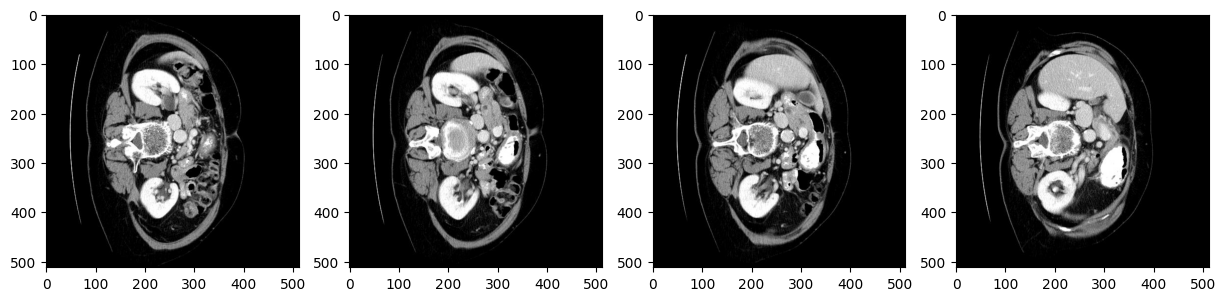

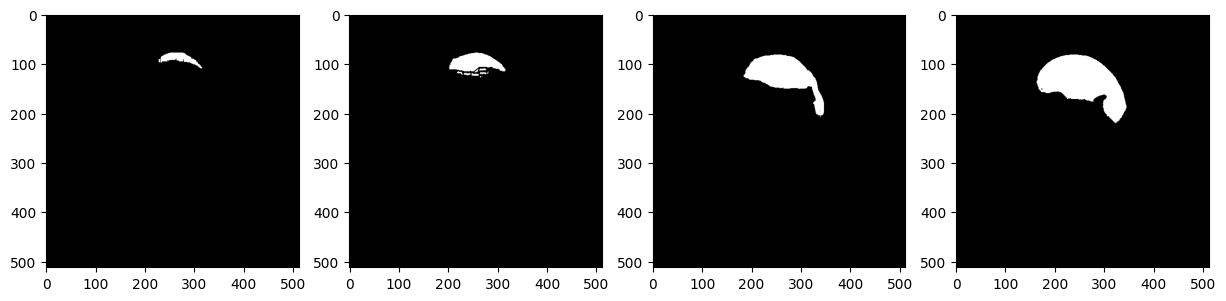

In [ ]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x


fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

In [ ]:
from tensorflow import keras
!pip install keras-unet-collection



from keras_unet_collection import models, utils

# the indicator of a fresh run
first_time_running = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 755.2 kB/s eta 0:00:00a 0:00:01


In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1


smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))


def voe_metric(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    voe = 1.0 - (intersection / union)
    return voe

def rvd_metric(y_true, y_pred):
    volume_pred = tf.reduce_sum(y_pred)
    volume_gt = tf.reduce_sum(y_true)
    rvd = ((volume_pred - volume_gt) / volume_gt)
    return rvd

def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    iou_score = intersection / (union + smooth)
    return iou_score

LR = 1e-4
opt = tf.keras.optimizers.legacy.Nadam(LR)
metrics = [dice_coef, recall, precision, f1_score, accuracy, iou, voe_metric, rvd_metric]

In [ ]:
logdir='/kaggle/working/logs'
tensorboard_callback1 = tf.keras.callbacks.TensorBoard(log_dir=logdir)
tensorboard_callback2 = tf.keras.callbacks.EarlyStopping(min_delta=0.0010, patience=5, verbose=1, mode='min', start_from_epoch=0)


# model1 = models.att_unet_2d((128, 128, 3), filter_num=[64, 128, 256, 512, 1024], n_labels=3,
#                            stack_num_down=2, stack_num_up=2, activation='ReLU',
#                            atten_activation='ReLU', attention='add', output_activation='Sigmoid',
#                            batch_norm=True, pool='max', unpool=False,
#                            backbone='VGG16', weights='imagenet',
#                            freeze_backbone=True, freeze_batch_norm=True,
#                            name='attunet')
# model1.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
# model1.summary()



model2 = models.unet_3plus_2d((128, 128, 3), n_labels=3, filter_num_down=[64, 128, 256, 512],
                             filter_num_skip='auto', filter_num_aggregate='auto',
                             stack_num_down=2, stack_num_up=1, activation='ReLU', output_activation='Sigmoid',
                             batch_norm=True, pool='max', unpool=False, deep_supervision=False, name='unet3plus')


model2.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model2.summary()



# model3 = models.r2_unet_2d((128, 128, 3), [64, 128, 256, 512], n_labels=3,
#                           stack_num_down=2, stack_num_up=1, recur_num=2,
#                           activation='ReLU', output_activation='Sigmoid',
#                           batch_norm=True, pool='max', unpool='nearest', name='r2unet')

# model3.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
# model3.summary()

Automated hyper-parameter determination is applied with the following details:
----------
	Number of convolution filters after each full-scale skip connection: filter_num_skip = [64, 64, 64]
	Number of channels of full-scale aggregated feature maps: filter_num_aggregate = 256
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 unet3plus_down0_0 (Conv2D)  (None, 128, 128, 64)         1728      ['input_1[0][0]']             
                                                                                                  
 unet3plus_down0_0_bn (Batc  (None, 128, 128, 64)         256       ['unet3plus_down0_0[0][0]']   
 hNormalization

In [ ]:
logdir='/kaggle/working/logs'
tensorboard_callback1 = tf.keras.callbacks.TensorBoard(log_dir=logdir)
tensorboard_callback2 = tf.keras.callbacks.EarlyStopping(min_delta=0.0010, patience=5, verbose=1, mode='min', start_from_epoch=0)

# print("For Attention U-Net 2D:")
# model1.fit(
#     train_dataset,
#     validation_data=valid_dataset,
#     epochs=EPOCHS,
#     steps_per_epoch=train_steps,
#     validation_steps=valid_steps,
#     callbacks=[tensorboard_callback1, tensorboard_callback2]
# )
# model1.save('AttentionUNet2D.hdf5')



print("For U-Net 3+ 2D:")
model2.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=[tensorboard_callback1, tensorboard_callback2]
)
model2.save('UNet3plus2D.hdf5')



# print("For R2 U-Net:")
# model3.fit(
#     train_dataset,
#     validation_data=valid_dataset,
#     epochs=EPOCHS,
#     steps_per_epoch=train_steps,
#     validation_steps=valid_steps,
#     callbacks=[tensorboard_callback1, tensorboard_callback2]
# )
# model3.save('R2UNet.hdf5')

For U-Net 3+ 2D:
Epoch 1/70
1916/1916 [==============================] - 496s 246ms/step - loss: 0.1743 - dice_coef: 0.8256 - recall: 0.8663 - precision: 0.8301 - f1_score: 0.8271 - accuracy: 0.9825 - iou: 0.7463 - voe_metric: 0.2537 - rvd_metric: 0.8246 - val_loss: 0.1454 - val_dice_coef: 0.8542 - val_recall: 0.9031 - val_precision: 0.8210 - val_f1_score: 0.8530 - val_accuracy: 0.9800 - val_iou: 0.7598 - val_voe_metric: 0.2402 - val_rvd_metric: 0.1288
Epoch 2/70
1916/1916 [==============================] - 395s 206ms/step - loss: 0.1295 - dice_coef: 0.8703 - recall: 0.8824 - precision: 0.8748 - f1_score: 0.8673 - accuracy: 0.9872 - iou: 0.7999 - voe_metric: 0.2001 - rvd_metric: 0.6326 - val_loss: 0.1443 - val_dice_coef: 0.8552 - val_recall: 0.8661 - val_precision: 0.8629 - val_f1_score: 0.8524 - val_accuracy: 0.9813 - val_iou: 0.7656 - val_voe_metric: 0.2344 - val_rvd_metric: 0.0266
Epoch 3/70
1916/1916 [==============================] - 396s 207ms/step - loss: 0.1150 - dice_coef: 0.8

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Checking on test data

test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

# print("For Attention U-Net 2D:")
# model1.evaluate(test_dataset, steps=test_steps)

print("For U-Net 3+ 2D:")
model2.evaluate(test_dataset, steps=test_steps)

# print("For R2 U-Net:")
# model3.evaluate(test_dataset, steps=test_steps)

For U-Net 3+ 2D:
240/240 [==============================] - 48s 199ms/step - loss: 0.0965 - dice_coef: 0.9036 - recall: 0.9211 - precision: 0.9026 - f1_score: 0.9038 - accuracy: 0.9868 - iou: 0.8368 - voe_metric: 0.1632 - rvd_metric: 0.0430


[0.09653295576572418,
 0.9035675525665283,
 0.921124279499054,
 0.9026040434837341,
 0.9038191437721252,
 0.986797034740448,
 0.8367835283279419,
 0.16321611404418945,
 0.04302056133747101]